<!-- dom:TITLE: Higher order sensitivity indices for interaction models -->
# Higher order sensitivity indices for interaction models
<!-- dom:AUTHOR: Vinzenz Gregor Eck at Expert Analytics -->
<!-- Author: -->  
**Vinzenz Gregor Eck**, Expert Analytics  
**Jacob Sturdy**, Department of Structural Engineering, NTNU  
**Leif Rune Hellevik**, Department of Structural Engineering, NTNU


Date: **Jul 13, 2018**  
Date: **Feb 1, 2026** Revised by LRH

In [1]:
# @title Install chaospy (Colab-friendly)

# Denne cellen sørger for at chaospy (og dermed numpoly) er tilgjengelig
# uten å tukle med numpy-installasjonen til Colab.

try:
    import chaospy as cp
    import numpoly
    import numpy as np
    print("chaospy er allerede installert.")
except ImportError:
    # Installer chaospy fra PyPI. Dette drar inn numpoly automatisk.
    %pip install chaospy==4.3.21 --no-cache-dir

    import chaospy as cp
    import numpoly
    import numpy as np

print("numpy  :", np.__version__)
print("numpoly:", numpoly.__version__)
print("chaospy:", cp.__version__)


chaospy er allerede installert.
numpy  : 2.2.6
numpoly: 1.3.6
chaospy: 4.3.20


In [2]:
# @title Layout fix, imports, and NumPy compatibility patch

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
HTML("""
<style>
div.cell.code_cell, div.output {
    max-width: 100% !important;
}
</style>
""")

from IPython.display import HTML

HTML("""
<style>
/* Make notebook content use full width */
.jp-NotebookPanel, .jp-Notebook, .jp-Notebook-container {
  width: 100% !important;
}

/* Prevent output area from forcing horizontal scrollbars */
.jp-OutputArea, .jp-OutputArea-output {
  overflow-x: visible !important;
}

/* If JupyterLab puts the output in a scroll box, disable it */
.output_scroll {
  overflow-x: visible !important;
  max-height: none !important;
}

/* Make figures responsive inside output area */
.jp-OutputArea-output figure, 
.jp-OutputArea-output img {
  max-width: 100% !important;
  height: auto !important;
}
</style>
""")


import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
import numpoly
import pandas as pd

%matplotlib inline
plt.rcdefaults()

# --- SAFE NumPy reshape patch (idempotent) ---
if not hasattr(np, "_original_reshape"):
    np._original_reshape = np.reshape

def reshape_compat(a, *args, **kwargs):
    newshape = kwargs.pop("newshape", None)
    if newshape is None:
        newshape = kwargs.pop("shape", None)

    if newshape is not None:
        return np._original_reshape(a, newshape, *args, **kwargs)
    return np._original_reshape(a, *args, **kwargs)

np.reshape = reshape_compat
print("✓ numpy.reshape safely patched (once)")





✓ numpy.reshape safely patched (once)


In [3]:
# @title Repo sync and environment setup (local + Colab safe)

import os, sys, subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REMOTE = "https://github.com/lrhgit/uqsa2025.git"

if IN_COLAB:
    REPO_PATH = Path("/content/uqsa2025")
    if not REPO_PATH.exists():
        print("Cloning repository...")
        subprocess.run(["git", "clone", REMOTE, str(REPO_PATH)], check=True)
    else:
        print("Updating existing repository...")
        subprocess.run(["git", "-C", str(REPO_PATH), "pull"], check=True)
    os.chdir(REPO_PATH)
else:
    # running locally → infer repo root from cwd
    cwd = Path.cwd().resolve()
    REPO_PATH = next(
        (p for p in [cwd] + list(cwd.parents) if (p / "python_source").exists()),
        None
    )
    if REPO_PATH is None:
        raise RuntimeError("Could not locate repo root with python_source")

# add python_source to sys.path
PY_SRC = REPO_PATH / "python_source"
if str(PY_SRC) not in sys.path:
    sys.path.insert(0, str(PY_SRC))

print("CWD:", Path.cwd())
print("Repo root:", REPO_PATH)
print("python_source exists:", PY_SRC.exists())
print("python_source in sys.path:", str(PY_SRC) in sys.path)


CWD: /Users/leifh/git/uqsa2025
Repo root: /Users/leifh/git/uqsa2025
python_source exists: True
python_source in sys.path: True


In [4]:
from monte_carlo import generate_sample_matrices_mc
from monte_carlo import calculate_sensitivity_indices_mc
from plot_sobol import plot_sobol_mc_vs_pce
from pretty_printing import (
    pretty_table,
    section_title,
    sobol_summary_table,
    uncertainty_summary_table,
)



unit_mmhg_pa = 133.3
unit_pa_mmhg = 1./unit_mmhg_pa
unit_cm2_m2 = 1. / 100. / 100.
unit_m2_cm2 = 1. / unit_cm2_m2

# A model with interaction
<div id="sec:non_additive_model"></div>

For convenience and simplicity, we consider the same model as before:

<!-- Equation labels as ordinary links -->
<div id="eq:non_add_model"></div>

$$
\begin{equation}
Y = \sum_{i=1}^{r} \Omega_i \, Z_i
\label{eq:non_add_model} \tag{1}
\end{equation}
$$

The only difference is that we render ([1](#eq:non_add_model))
non-additive by letting both $\Omega_i$ and $Z_i$ be random
variables. By doing so our model will have products of two distinct
random variables, and consequently it will be a non-additive model, as it no longer fulfills the criterion:



<hr/>
**Definition: Additive model.**

An [additive model](https://chemicalstatistician.wordpress.com/2014/03/07/applied-statistics-lesson-of-the-day-additive-models-vs-interaction-models-in-2-factor-experimental-designs/) is the arithmetic sum of its individual random variables.
<hr/>



In constrast, a `non-additive model`, is `not` simply a sum of its individual
random variables. For our model ([1](#eq:non_add_model)) the effect of
$Z_i$ on $Y$ depends on the value of $\Omega_i$, and for this reason
non-additive moldels are also often called `interaction models`.

Note that $ Y = \sum_{i=1}^{r} \Omega_i \, Z_i^2$, will be an additive
model for constant $\Omega_i$, but non-linear the individual $Z_i$.

For our non-additive (interaction) model ([1](#eq:non_add_model)) we
assume $\Omega_i$ and $Z_i$ to be normaly distributed random
variables:

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
Z_i  \sim N(0, \sigma_{Z_i}), \qquad i=1,2, \ldots, r 
\label{_auto1} \tag{2}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation} 
\Omega_i  \sim N(\mu_{\Omega_i}, \sigma_{\Omega_i})
\label{_auto2} \tag{3}
\end{equation}
$$

Which means that the distributions of $Z_i$ are unchanged, whereas the
mean values $\mu_{\Omega_i}$ of the distributions of $\Omega_i$ are
chosen to be non-zero:

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\mu_{\Omega_i} = 0.5 i, \qquad i=1,2, \ldots, r \qquad \textsf{such that} \qquad
\bar{\Omega}_1 < \bar{\Omega}_3 < \bar{\Omega}_3 <\bar{\Omega}_4
\label{_auto3} \tag{4}
\end{equation}
$$

The number of random variables for our interaction model
([1](#eq:non_add_model)) has increased to $N_{rv} = 2\, r$ and we arrange them in a vector in the following manner:

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\mathbf{X}= \left ( Z_1, Z_2, \ldots, Z_r, \Omega_1, \Omega_2, \ldots, \Omega_r \right)
\label{_auto4} \tag{5}
\end{equation}
$$

Below we will demonstrate how the Sobol sensitivity indices may be
computed with both the Monte Carlo Method and the Polynomial Chaos
method. The python code for the model is:

In [5]:
# start the linear model
def linear_model(w, z):
    return np.sum(w*z, axis=1)

### Definition of the random input variables

In this example of interaction models we set $r=4$ in
([1](#eq:non_add_model)) and in the code snippet below we let the
numpy-arrays `zm` and `wm` hold the expectations in the first column
and the standard deviation in the second column of $Z_i$ and
$\Omega_i$, repectively. You may uncomment the lines in the code
snippet to set values of e.g. the standard deviations yourself.

In [6]:
    # definition of mu and sig for z and w
    N_terms = 4
    c = 0.5
    zm = np.array([[0., i] for i in range(1, N_terms+1)])
    wm = np.array([[i * c, i] for i in range(1, N_terms+1)])

    # to see the effect of changing the values in zm uncomment and change one of these lines and re-run

    # zm[0, 1] = 1
    # zm[1, 1] = 20
    # zm[2, 1] = 3
    # zm[3, 1] = 10

In this example we choose to set $r=4$ and use the chaospy package to
define our random input variables for our model
([1](#eq:non_add_model)). The function `generate_distributions` takes
two numpy-arrays `zm` and `wm` as arguments, where `wm` is
optional. Whenever `wm` is passed to the function (not `None`) it is
treated as an array holding the expectation and standard deviations as
`zm` and appended to the `xm` array to hold all the expectations and
standard deviations for both $Z_i$ and $\Omega_i$. The marginal
distributions (or probability density functions or pdf for short) for each element in `xm` are generated with repeated calls to chaospy for each elmement in `xm`: `[cp.Normal(*mu_sig) for mu_sig in xm]`. Note that the `*-operator` is used to unpack the arguments out of a list or tuple.   

Finally, we generate the the joint pdf by unpacking all the elements
in the list `marginal distributions` and passing them to `cp.J`, the
joint probability density function of Chaospy.

In [7]:
# definition of the distributions
def generate_distributions(zm, wm=None):
    # define marginal distributions
    if wm is not None:
        zm = np.append(zm, wm, axis=0)
    marginal_distributions = [cp.Normal(*mu_sig) for mu_sig in zm]
    # define joint distributions
    jpdf = cp.J(*marginal_distributions)

    return jpdf

# Scatter plots

In [8]:
    # generate the joint distribution
    jpdf = generate_distributions(zm, wm)

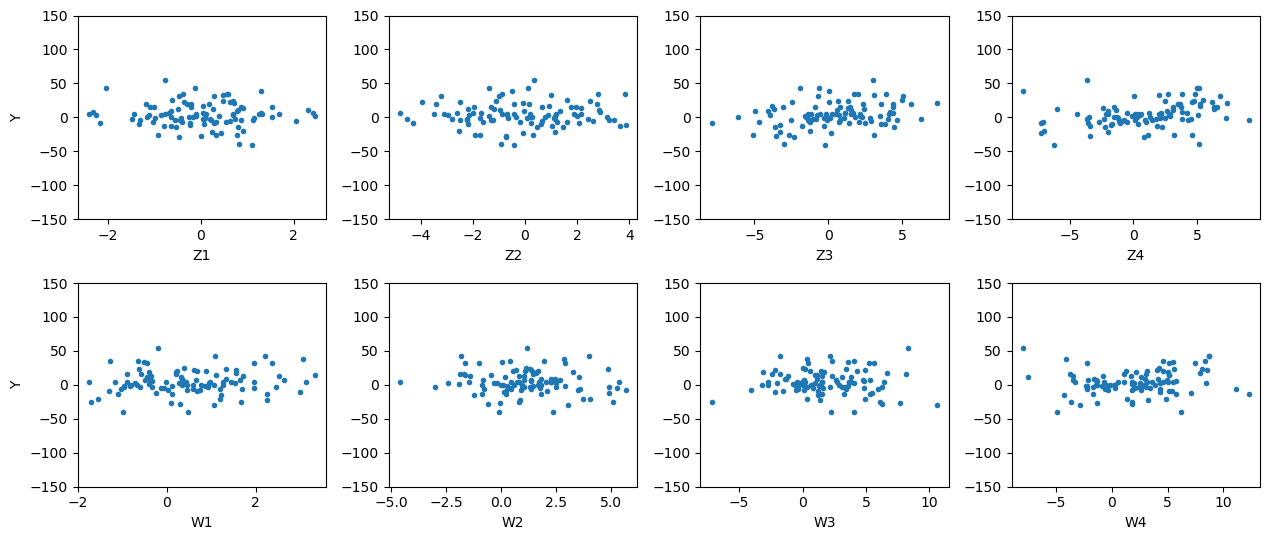

In [9]:
# Scatter plots of data for visual inspection of sensitivity

N_plot = 100
N_prms = len(jpdf)
N_terms = N_prms // 2

Xs = jpdf.sample(N_plot, rule="random").T

Zs = Xs[:, :N_terms]   # first half
Ws = Xs[:, N_terms:]   # second half

Ys = linear_model(Ws, Zs)

plt.figure("Scatter plots", figsize=(3.2*N_terms, 5.5))

for k in range(N_terms):
    plt.subplot(2, N_terms, k + 1)
    plt.plot(Zs[:, k], Ys, ".")
    if k == 0:
        plt.ylabel("Y")
    plt.xlabel(f"Z{k+1}")
    plt.ylim([-150, 150])

    plt.subplot(2, N_terms, k + 1 + N_terms)
    plt.plot(Ws[:, k], Ys, ".")
    if k == 0:
        plt.ylabel("Y")
    plt.xlabel(f"W{k+1}")
    plt.ylim([-150, 150])

plt.tight_layout()


# First order sensitivity coefficients

### Analytical computation of the sensitivity indices

The calculation of the sensitivity indices for this model can be done analytically.
We will use this as reference for the comparison with the results of the Monte Carlo and polynomial chaos method.

In [10]:
    # calculate the analytic sensitivity coefficients

    VarY = np.sum(zm[:, 1]**2 * (wm[:, 0]**2 + wm[:, 1]**2), axis=0)
    Sz = wm[:, 0]**2 * zm[:, 1]**2/VarY # first order indices
    Sw = np.zeros_like(Sz)
    Szw= wm[:, 1]**2 * zm[:, 1]**2/VarY  # second order indices
    StZ = (wm[:, 0]**2 * zm[:, 1]**2 + wm[:, 1]**2 * zm[:, 1]**2)/VarY # total indices
    Stw = (wm[:, 1]**2 * zm[:, 1]**2)/VarY

    # join sensitivity arrays
    Sa = np.append(Sz, Sw)
    Sta = np.append(StZ, Stw)

Now we will calculate of the sensitivity indices with both the Monte Carlo and polynomial chaos method:

### Define functions for computing the sensitivity indices with the MCM

In [11]:
# calculate sens indices of non additive model
def monte_carlo_sens_nonlin(Ns, jpdf, sample_method='R'):

    N_prms = len(jpdf)

    # 1. Generate sample matrices
    XA, XB, XC = generate_sample_matrices_mc(Ns, N_prms, jpdf, sample_method)

    # 2. Evaluate the model
    Y_A, Y_B, Y_C = evaluate_non_additive_linear_model(XA, XB, XC)

    # 3. Approximate the sensitivity indices
    S, ST = calculate_sensitivity_indices_mc(Y_A, Y_B, Y_C)

    return XA, XB, XC, Y_A, Y_B, Y_C, S, ST
# end calculate sens indices of non additive model


# model evaluation
def evaluate_non_additive_linear_model(X_A, X_B, X_C):

    N_prms = X_A.shape[1]
    Ns = X_A.shape[0]
    N_terms = int(N_prms / 2)
    # 1. evaluate sample matrices X_A
    Z_A = X_A[:, :N_terms]  # Split X in two vectors for X and W
    W_A = X_A[:, N_terms:]
    Y_A = linear_model(W_A, Z_A)

    # 2. evaluate sample matrices X_B
    Z_B = X_B[:, :N_terms]
    W_B = X_B[:, N_terms:]
    Y_B = linear_model(W_B, Z_B)

    # 3. evaluate sample matrices X_C
    Y_C = np.empty((Ns, N_prms))
    for i in range(N_prms):
        x = X_C[i, :, :]
        z = x[:, :N_terms]
        w = x[:, N_terms:]
        Y_C[:, i] = linear_model(w, z)

    return Y_A, Y_B, Y_C

### Define functions for computing the sensitivity indices with polynomial chaos expansions

In [12]:
def polynomial_chaos_sens_from_samples(samples_pc, jpdf, poly, return_reg=False, compute_total=True):
    N_terms = int(len(jpdf) / 2)

    transposed_samples = samples_pc.T
    samples_z = transposed_samples[:, :N_terms]
    samples_w = transposed_samples[:, N_terms:]
    model_evaluations = linear_model(samples_w, samples_z)

    gpce_regression = cp.fit_regression(poly, samples_pc, model_evaluations)

    Spc = cp.Sens_m(gpce_regression, jpdf)
    if compute_total:
        Stpc = cp.Sens_t(gpce_regression, jpdf)
    else:
        Stpc = None

    if return_reg:
        return Spc, Stpc, gpce_regression
    return Spc, Stpc


### Perform the computations

**MCM**

In [13]:
    # Monte Carlo
    #Ns_mc = 1000000 # Number of samples mc
    Ns_mc = 10000 # Number of samples mc
    # calculate sensitivity indices with mc
    A_s, B_s, C_s, f_A, f_B, f_C, Smc, Stmc = monte_carlo_sens_nonlin(Ns_mc, jpdf)

**Polynomial chaos**

In [16]:
# compute with Polynomial Chaos (updated)

Ns_pc = 100
polynomial_order = 2

# basis
poly = cp.expansion.stieltjes(polynomial_order, jpdf)

# samples for regression
samples_pc = jpdf.sample(size=Ns_pc, rule="S")  # or "R"

# calculate sensitivity indices with PCE regression
Spc, Stpc, gpce_reg = polynomial_chaos_sens_from_samples(
    samples_pc, jpdf, poly,
    return_reg=True,
    compute_total=True   # set False if you want to skip ST (faster)
)


**Compare the computations**

In [17]:
#print Sobol-indices in a table
row_labels = [f"X_{i}" for i in range(1, N_terms*2 + 1)]

S = np.column_stack((Sa, Spc, Smc, Sta, Stpc, Stmc))

S_table = pd.DataFrame(
    S,
    columns=['Sa', 'Spc', 'Smc', 'Sta', 'Stpc', 'Stmc'],
    index=row_labels
)

section_title("Comparison of Sobol sensitivity indices")

pretty_table(
    S_table,
    floatfmt=".3f"
)


,Sa,Spc,Smc,Sta,Stpc,Stmc
X_1,0.001,0.001,0.000,0.003,0.003,0.003
X_2,0.009,0.009,0.011,0.045,0.045,0.046
X_3,0.046,0.046,0.053,0.229,0.229,0.225
X_4,0.145,0.145,0.134,0.723,0.723,0.725
X_5,0.000,0.000,0.000,0.002,0.002,0.002
X_6,0.000,0.000,0.000,0.036,0.036,0.037
X_7,0.000,0.000,0.002,0.183,0.183,0.179
X_8,0.000,0.000,0.015,0.579,0.579,0.567


In [18]:
# compare the computations
row_labels = [f"X_{i}" for i in range(1, N_terms*2 + 1)]

S = np.column_stack((Sa, Spc, Smc, Sta, Stpc, Stmc))

S_table = pd.DataFrame(
    S,
    columns=['Sa', 'Spc', 'Smc', 'Sta', 'Stpc', 'Stmc'],
    index=row_labels
)

section_title("Comparison of Sobol sensitivity indices")

pretty_table(
    S_table,
    floatfmt=".3f"
)


,Sa,Spc,Smc,Sta,Stpc,Stmc
X_1,0.001,0.001,0.000,0.003,0.003,0.003
X_2,0.009,0.009,0.011,0.045,0.045,0.046
X_3,0.046,0.046,0.053,0.229,0.229,0.225
X_4,0.145,0.145,0.134,0.723,0.723,0.725
X_5,0.000,0.000,0.000,0.002,0.002,0.002
X_6,0.000,0.000,0.000,0.036,0.036,0.037
X_7,0.000,0.000,0.002,0.183,0.183,0.179
X_8,0.000,0.000,0.015,0.579,0.579,0.567


# Second and higher order sensitivity coefficients

In the [sensitivity introduction notebook](sensitivity_introduction.ipynb) we introduced the first order
sensitivity indices as:

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
S_i = \frac{\text{V}_{Z_i}(E_{Z_{\sim i}} (Y\;|\;Z_i))}{\text{V}(Y)}
\label{_auto5} \tag{6}
\end{equation}
$$

Based on the seminal works of the Russian mathematician Sobol, we may
introduce decompositions of the form:

<!-- Equation labels as ordinary links -->
<div id="eq:Vi"></div>

$$
\begin{equation}
V_i = V \left ( E(Y\,|\, X_i) \right ) 
\label{eq:Vi} \tag{7} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:Vij"></div>

$$
\begin{equation} 
V_{ij} = V \left ( E(Y\,|\, X_i, X_j) \right )  - V_i - V_j 
\label{eq:Vij} \tag{8} 
\end{equation}
$$

where we for convenience have dropped the subscripts for the
expectation oprerator and the variance operator. Keep in mind
that the outer operator always operates on the conditioned factors, in
this case $X_i$ and $X_j$.

   * The second order conditional variance $V \left ( E(Y\,|\, X_i, X_j) \right )$ is a measure of the combined effect of the pair $(X_i,X_j)$.

   * The $V_{ij}$ is interaction term between the factors $X_i$ and $X_j$ and the combined effect minus the first order effetcs $V_i$ and $V_j$.

   * The $V_{ij}$ captures the part of $V(Y)$ which cannot be expressed as a sum of the separate effects of $X_i$ and $X_j$

By repeated introduction of progressively higher order conditional
variences, the total variance of the output $V(Y)$ may be presented as
a ANOVA-HDMR decomposition:

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
V(Y) = \sum_{i} V_i +\sum_{i}\sum_{j>i} V_{ij}+ \sum_{i}\sum_{j>i}\sum_{l>j} V_{ijl}+\ldots + V_{12...k}
\label{_auto6} \tag{9}
\end{equation}
$$

which by division of $V(Y)$ yields the very useful relation:

<!-- Equation labels as ordinary links -->
<div id="eq:S_decomp"></div>

$$
\begin{equation}
\sum_{i} S_i +\sum_{i}\sum_{j>i} S_{ij}+ \sum_{i}\sum_{j>i}\sum_{l>j} S_{ijl}+\ldots + S_{12...k} =1 
\label{eq:S_decomp} \tag{10}
\end{equation}
$$

**Higher order sensitivity indices**

The variance-based sensitivity indices in ([10](#eq:S_decomp)) represent
a way to express 100% of the variance of $Y$ regardless of whether $Y$
is additive or non-additive. In other words, ([10](#eq:S_decomp))
provides a complete quantification of the sensitivity of the model
with respect to its predictive factors. The only problem is that
([10](#eq:S_decomp)) may have as many as $2^k-1$ terms for $k$ input factors.

  * For $k=3$ this gives $2^3-1=7$ indices: $S_1$, $S_2$, $S_3$,$S_{12}$, $S_{13}$, $S_{23}$, $S_{123}$,

  * For $k=10$ we get $2^{10}-1=1023$ indices, which is neither tractable and informative in practice. 

Of the $2^k-1$ terms we have:
  * $k$ first order indices $S_i$

  * $ {k\choose 2} =\frac{k!}{2!\,(k-2)!}$ second order indices $S_{ij}$

  * $ {k\choose 3}$ third order indices $S_{ijk}$

  * ..and so on

The computation of the second order indices for our model example is
illustrated in the code snippet below. For our simple model,
interaction terms higher then second order will be zero. Consequently,
by ([10](#eq:S_decomp)) the sum of the first and second order indicecs
should sum up to unity. We test that this is indeed the case by
printing the sum. Further, we compute the error for the indices
computed with `chaospy` for each individual index.

In [19]:
  # Second order indices with gpc
  
S2 = cp.Sens_m2(gpce_reg, jpdf)  # second order indices with gpc

S2_df = pd.DataFrame(
    S2,
    columns=row_labels,
    index=row_labels
)

section_title("Second-order Sobol indices $S_{ij}$ (PCE)")

pretty_table(
    S2_df,
    floatfmt=".3f"
)


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8
X_1,0.000,0.000,0.000,0.000,0.002,-0.000,-0.000,-0.000
X_2,0.000,0.000,0.000,0.000,-0.000,0.036,-0.000,-0.000
X_3,0.000,0.000,0.000,0.000,-0.000,-0.000,0.183,-0.000
X_4,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.579
X_5,0.002,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
X_6,-0.000,0.036,-0.000,-0.000,0.000,0.000,0.000,0.000
X_7,-0.000,-0.000,0.183,-0.000,0.000,0.000,0.000,0.000
X_8,-0.000,-0.000,-0.000,0.579,0.000,0.000,0.000,0.000


#### Why do we sum only (i<j) in the second-order indices?

The matrix (S_{ij}) contains **pairwise interaction effects** between input variables.

* Each interaction appears **twice** in the matrix $S_{ij} = S_{ji}$.
* The diagonal terms (S_{ii}) should be zero and are ignored.

To avoid double counting, we therefore sum **only unique pairs**:
$$
\sum_{i<j} S_{ij}.
$$

For this model, which has no higher-order interactions, we expect:
$$
 \sum_i S_i + \sum_{i<j} S_{ij} \approx 1.
$$


In [20]:
# Sum of second-order Sobol indices (unique interactions only)
SumS2 = np.sum(np.triu(S2, k=1))  # sum over i<j

print(f"Sum Sij (i<j)   = {SumS2:2.2f}")
print(f"Sum Si + Sij    = {np.sum(Spc) + SumS2:2.2f}")


Sum Sij (i<j)   = 0.80
Sum Si + Sij    = 1.00


#### Comparing analytical and PCE-based second-order interaction indices

In this model, the input variables are ordered as two blocks:
$$
(Z_1,\dots,Z_N,\; W_1,\dots,W_N).
$$

From the analytical solution, we know that **only interactions between matching pairs**
$$
(Z_i, W_i)
$$
are non-zero.

We therefore extract these terms from the PCE-based second-order Sobol matrix and compare them with the analytical values.  
The relative error is computed as
$$
\frac{S_{ij}^{\text{PCE}} - S_{ij}^{\text{analytical}}}{S_{ij}^{\text{analytical}}}.
$$

This comparison verifies that the polynomial chaos expansion correctly captures the expected interaction effects.


In [21]:
# Compare nonzero second-order indices with analytical indices
# (matching interaction pairs Zi–Wi)

Szw_pc = [S2[i, i + N_terms] for i in range(N_terms)]

Szw_df = pd.DataFrame(
    {
        "Szw (PCE)": Szw_pc,
        "Szw (analytical)": Szw,
        "rel. error": (np.array(Szw_pc) - np.array(Szw)) / np.array(Szw),
    },
    index=[f"Z{i+1}–W{i+1}" for i in range(N_terms)]
)

section_title("Analytical vs PCE-based second-order interaction indices")

pretty_table(
    Szw_df,
    floatfmt=".3f"
)


,Szw (PCE),Szw (analytical),rel. error
Z1–W1,0.002,0.002,0.000
Z2–W2,0.036,0.036,-0.000
Z3–W3,0.183,0.183,-0.000
Z4–W4,0.579,0.579,0.000


The important thing to realize is that the number of interaction terms
increase exponentialy as the number of input factors $k$ increase.  In
this case, the remedy offered by variance based analysis is to compute
the 'total effect term', which we will outline in the following.



# Convergence Analysis
## Monte Carlo Method


#### Convergence analysis

Sensitivity indices are estimated numerically and therefore depend on the number of model evaluations.

To assess their reliability, we study how the **error in the Sobol indices decreases** as the number of samples increases. For the Monte Carlo method, the estimated indices are compared with the analytical reference values using the absolute error:
$$
\lvert S_i^{\text{MC}} - S_i^{\text{analytical}} \rvert,
\qquad
\lvert S_{T_i}^{\text{MC}} - S_{T_i}^{\text{analytical}} \rvert.
$$

The convergence plots illustrate how many samples are needed to obtain accurate estimates and highlight the computational cost of Monte Carlo–based sensitivity analysis.

#### Averaging over repeated Monte Carlo runs

For a fixed number of samples $N_{\text{smpl}}$, the Monte Carlo estimates of the Sobol indices are **random variables**:  
each run uses a new random sample and therefore produces slightly different results.

To reduce the effect of this randomness, we repeat the Monte Carlo estimation several times and average the errors.

For each value of $N_{\text{smpl}}$:
$$
j = 1, \dots, 5
$$
independent Monte Carlo simulations are performed, each with a new random sample set.  
The absolute errors are then averaged over these runs:
$$
\text{error}(N_{\text{smpl}}) = \frac{1}{5} \sum_{j=1}^{5}
\lvert S^{(j)} - S^{\text{analytical}} \rvert.
$$

This procedure yields a **more stable and reliable estimate of the convergence rate**, reducing fluctuations caused by random sampling.


This may take a while. Be patient!
(You can also reduce iteration number for averaging.)

Convergence analysis for the monte carlo method:

MC convergence analysis:
    N_smpl 10000
         finished with iteration 1 of 5
         finished with iteration 2 of 5
         finished with iteration 3 of 5
         finished with iteration 4 of 5
         finished with iteration 5 of 5
    N_smpl 50000
         finished with iteration 1 of 5
         finished with iteration 2 of 5
         finished with iteration 3 of 5
         finished with iteration 4 of 5
         finished with iteration 5 of 5
    N_smpl 100000
         finished with iteration 1 of 5
         finished with iteration 2 of 5
         finished with iteration 3 of 5
         finished with iteration 4 of 5
         finished with iteration 5 of 5
    N_smpl 500000
         finished with iteration 1 of 5
         finished with iteration 2 of 5
         finished with iteration 3 of 5
         finished with iteration 4 of 5
         finished with iteration 5 of 5
    N_smpl 1000000
         finished with iteration 1 of 5
         finished with iteration 2 of 5
      

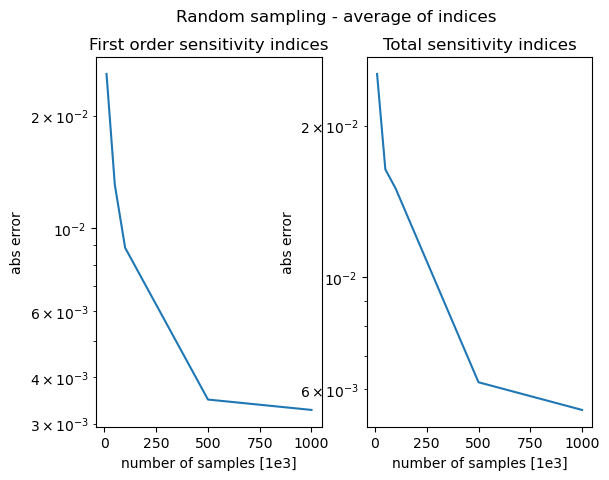

In [22]:
        # Convergence Monte Carlo with random sampling
        list_of_samples = np.array([10000, 50000, 100000, 500000, 1000000])
        #list_of_samples = np.array([10000, 50000, 100000, 500000])
        s_mc_err = np.zeros((len(list_of_samples), N_prms))
        st_mc_err = np.zeros((len(list_of_samples), N_prms))
        # average over
        N_iter = 5
        print('MC convergence analysis:')
        for i, N_smpl in enumerate(list_of_samples):
            print('    N_smpl {}'.format(N_smpl))
            for j in range(N_iter):
                A_s, XB, XC, Y_A, Y_B, Y_C, S, ST = monte_carlo_sens_nonlin(N_smpl,
                                                                                jpdf,
                                                                                sample_method='R')
                s_mc_err[i] += np.abs(S - Sa)
                st_mc_err[i] += np.abs(ST - Sta)
                print('         finished with iteration {} of {}'.format(1 + j, N_iter))
            s_mc_err[i] /= float(N_iter)
            st_mc_err[i] /= float(N_iter)
        # Plot results for monte carlo
        fig_random = plt.figure('Random sampling - average of indices')
        fig_random.suptitle('Random sampling - average of indices')

        ax = plt.subplot(1, 2, 1)
        plt.title('First order sensitivity indices')
        _=plt.plot(list_of_samples / 1000, np.sum(s_mc_err, axis=1), '-')
        ax.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

        ax1 = plt.subplot(1, 2, 2)
        plt.title('Total sensitivity indices')
        _=plt.plot(list_of_samples / 1000, np.sum(st_mc_err, axis=1), '-')
        ax1.set_yscale('log')
        _=plt.ylabel('abs error')
        _=plt.xlabel('number of samples [1e3]')

## Polynomial Chaos
PCE can be more sample-efficient than Monte Carlo for smooth models, but the regression + index extraction has its own computational cost.
Convergence analysis for the polynomial chaos method:

PCE convergence (vary polynomial order):
  order p=1:  M=   9, Ns=   27, sum|S_pc-Sa|=8.875e-01
  order p=2:  M=  45, Ns=  135, sum|S_pc-Sa|=4.504e-16

------------------------------------------------------------


,polynomial order p,basis size M,samples Ns,sum |S_PCE - S_analytical|
0,1.00e+00,9.00e+00,2.70e+01,8.87e-01
1,2.00e+00,4.50e+01,1.35e+02,4.50e-16


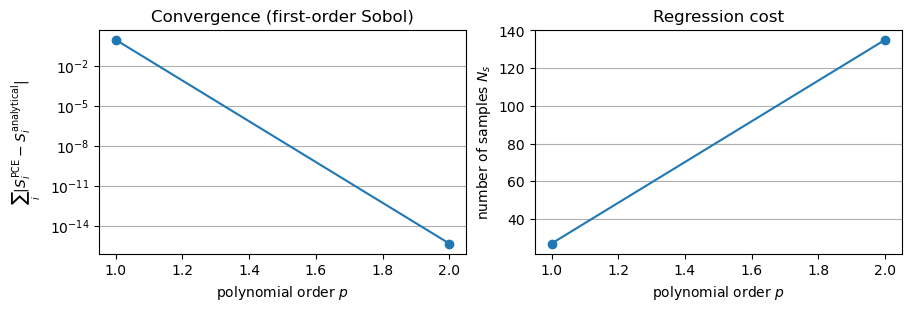

In [27]:
# ------------------------------------------------------------
# PCE "convergence" analysis: vary polynomial order (robust)
#   - avoids cp.Sens_t (slow/hangs in your setup)
#   - keeps sample size proportional to basis size
#   - measures error in first-order Sobol indices vs analytical
# ------------------------------------------------------------

print("PCE convergence (vary polynomial order):")

orders = [1, 2]          # keep short for speed
oversampling = 3               # Ns = oversampling * M
rule = "S"                     # Sobol sampling tends to be more stable

err_S_sum = []                 # sum abs error across parameters
Ns_list = []                   # store Ns used for each order

for p in orders:
    # 1) basis size
    poly = cp.expansion.stieltjes(p, jpdf)
    M = len(poly)
    Ns = int(oversampling * M)
    Ns_list.append(Ns)

    # 2) sample + evaluate model
    samples = jpdf.sample(size=Ns, rule=rule)      # (dim, Ns)
    trans = samples.T                               # (Ns, dim)
    N_terms = int(len(jpdf) / 2)
    z = trans[:, :N_terms]
    w = trans[:, N_terms:]
    y = linear_model(w, z)                          # (Ns,)

    # 3) regression PCE
    pce = cp.fit_regression(poly, samples, y)

    # 4) first-order Sobol indices (only)
    S_pc = cp.Sens_m(pce, jpdf)                     # (dim,)

    # 5) error vs analytical
    err = np.sum(np.abs(S_pc - Sa))
    err_S_sum.append(err)

    print(f"  order p={p}:  M={M:4d}, Ns={Ns:5d}, sum|S_pc-Sa|={err:.3e}")


# Visual separation between runtime feedback and final results
print("\n" + "-"*60)
display(section_title("Final PCE convergence results (first-order Sobol indices)"))

# Pretty print convergence summary
conv_table = pd.DataFrame({
    "polynomial order p": orders,
    "basis size M": [len(cp.expansion.stieltjes(p, jpdf)) for p in orders],
    "samples Ns": Ns_list,
    "sum |S_PCE - S_analytical|": err_S_sum,
})

pretty_table(
    conv_table,
    floatfmt=".2e"
)

# Plot
# Plot (robust for tiny errors)
err = np.array(err_S_sum, dtype=float)
Ns_arr = np.array(Ns_list, dtype=int)

# Avoid log(0) and avoid weird behavior near machine precision
eps = 1e-16
err_plot = np.maximum(err, eps)

# --- Compact horizontal plots for PCE convergence ---

plt.close("all")

fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 3),          # width x height (adjust height here)
    constrained_layout=True
)

# --- Left: convergence error ---
axes[0].plot(orders, err_plot, "o-")
axes[0].set_yscale("log")
axes[0].set_xlabel("polynomial order $p$")
axes[0].set_ylabel(r"$\sum_i |S_i^{\mathrm{PCE}} - S_i^{\mathrm{analytical}}|$")
axes[0].set_title("Convergence (first-order Sobol)")
axes[0].grid(True, which="both", axis="y")

# --- Right: sample count ---
axes[1].plot(orders, Ns_arr, "o-")
axes[1].set_xlabel("polynomial order $p$")
axes[1].set_ylabel("number of samples $N_s$")
axes[1].set_title("Regression cost")
axes[1].grid(True, axis="y")

plt.show()


### Reflection: monte carlo vs polynomial chaos

* How does the **cost of one model evaluation** affect whether MC or PCE is preferable?
* MC spends computation on **sampling**, while PCE spends computation on **building a surrogate**.
  When is it more efficient to learn the model rather than repeatedly evaluate it?
* PCE assumes a **smooth model response**.
  How might non-smooth behaviour or numerical noise change your choice of method?
